# Ch08_2.로지스틱 회귀분석

## 1.기본 package 설정

In [1]:
## 1.기본
import numpy as np  # numpy 패키지 가져오기
import matplotlib.pyplot as plt # 시각화 패키지 가져오기

## 2.데이터 가져오기
import pandas as pd # csv -> dataframe으로 전환
from sklearn import datasets # python 저장 데이터 가져오기

## 3.데이터 전처리
from sklearn.preprocessing import StandardScaler # 연속변수의 표준화
from sklearn.preprocessing import LabelEncoder # 범주형 변수 수치화

# 4. 훈련/검증용 데이터 분리
from sklearn.model_selection import train_test_split 

## 5.분류모델구축 (3장.p.83~130)
# from sklearn.tree import DecisionTreeClassifier # 결정 트리
# from sklearn.naive_bayes import GaussianNB # 나이브 베이즈
# from sklearn.neighbors import KNeighborsClassifier # K-최근접 이웃
# from sklearn.ensemble import RandomForestClassifier # 랜덤 포레스트
# from sklearn.ensemble import BaggingClassifier # 앙상블
# from sklearn.linear_model import Perceptron # 퍼셉트론
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀 모델
# from sklearn.svm import SVC # 서포트 벡터 머신(SVM)
# from sklearn.neural_network import MLPClassifier # 다층인공신경망

## 6.모델검정
from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score # 정확도, 민감도 등
from sklearn.metrics import roc_curve, auc # ROC 곡선 그리기

## 7.최적화
from sklearn.model_selection import cross_validate # 교차타당도
from sklearn.pipeline import make_pipeline # 파이프라인 구축
from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV # 하이퍼파라미터 튜닝

## 2.데이터 가져오기

### 2.1 데이터프레임으로 저장
- 원본데이터(csv)를 dataframe 형태로 가져오기(pandas)

In [2]:
bank_df = pd.read_csv('UniversalBank.csv')
bank_df.head()

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


- 자료구조 살펴보기

In [3]:
bank_df.shape

(5000, 14)

In [4]:
# 자료구조 살펴보기
bank_df.keys()

Index(['ID', 'Age', 'Experience', 'Income', 'ZIPCode', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'PersonalLoan', 'SecuritiesAccount',
       'CDAccount', 'Online', 'CreditCard'],
      dtype='object')

### 2.2 data와 target으로 분리
- 필요한 데이터만 추출
- data: X, target: y 로 분리

In [5]:
X = bank_df.drop (['ID','ZIPCode','PersonalLoan'], axis=1)
X.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,SecuritiesAccount,CDAccount,Online,CreditCard
0,25,1,49,4,1.6,1,0,1,0,0,0
1,45,19,34,3,1.5,1,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,1


In [6]:
y = bank_df['PersonalLoan']
np.bincount(y)

array([4520,  480], dtype=int64)

## 3.데이터 전처리

- 문자형 자료를 숫자(범주형)로 인코딩 -> 범주형 변수를 가변수로 처리 : One Hot Encording
- 숫자형 자료를 표준화
- 단, 결정나무, 랜덤 포레스트, 나이브 베이즈 분류 : 원본데이터 그대로 유지

### 3.1 data(X) 수치형 데이터 표준화 
- X.keys()에서 index 키를 가져옴 ['Age', 'Experience', 'Income', 'Family', 'CCAvg']

In [7]:
stdsc = StandardScaler()
X.iloc[:,[0,1,2,3,4,6]]= stdsc.fit_transform(X.iloc[:,[0,1,2,3,4,6]])

In [8]:
X.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,SecuritiesAccount,CDAccount,Online,CreditCard
0,-1.774417,-1.666078,-0.538229,1.397414,-0.193385,1,-0.555524,1,0,0,0
1,-0.029524,-0.096330,-0.864109,0.525991,-0.250611,1,-0.555524,1,0,0,0
2,-0.552992,-0.445163,-1.363793,-1.216855,-0.536736,1,-0.555524,0,0,0,0
3,-0.901970,-0.968413,0.569765,-1.216855,0.436091,2,-0.555524,0,0,0,0
4,-0.901970,-1.055621,-0.625130,1.397414,-0.536736,2,-0.555524,0,0,0,1


### 3.2 data(X) 레이블 인코딩
- 질변변수 가변수화
- 가변수 처리시 문자로 처리를 해야 변수명 구분이 쉬움

In [9]:
X['Education'] = X['Education'].replace ([1,2,3], ['Under','Grad','Prof'])

In [10]:
X.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,SecuritiesAccount,CDAccount,Online,CreditCard
0,-1.774417,-1.666078,-0.538229,1.397414,-0.193385,Under,-0.555524,1,0,0,0
1,-0.029524,-0.096330,-0.864109,0.525991,-0.250611,Under,-0.555524,1,0,0,0
2,-0.552992,-0.445163,-1.363793,-1.216855,-0.536736,Under,-0.555524,0,0,0,0
3,-0.901970,-0.968413,0.569765,-1.216855,0.436091,Grad,-0.555524,0,0,0,0
4,-0.901970,-1.055621,-0.625130,1.397414,-0.536736,Grad,-0.555524,0,0,0,1


In [11]:
X.keys()

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'SecuritiesAccount', 'CDAccount', 'Online', 'CreditCard'],
      dtype='object')

In [12]:
X = pd.get_dummies(X[['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education', 
                      'Mortgage', 'SecuritiesAccount', 'CDAccount', 'Online', 'CreditCard']],
                   columns=['Education'],
                   drop_first = True)

In [13]:
X.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,SecuritiesAccount,CDAccount,Online,CreditCard,Education_Prof,Education_Under
0,-1.774417,-1.666078,-0.538229,1.397414,-0.193385,-0.555524,1,0,0,0,0,1
1,-0.029524,-0.096330,-0.864109,0.525991,-0.250611,-0.555524,1,0,0,0,0,1
2,-0.552992,-0.445163,-1.363793,-1.216855,-0.536736,-0.555524,0,0,0,0,0,1
3,-0.901970,-0.968413,0.569765,-1.216855,0.436091,-0.555524,0,0,0,0,0,0
4,-0.901970,-1.055621,-0.625130,1.397414,-0.536736,-0.555524,0,0,0,1,0,0


### 3.2 Class(target) 레이블 인코딩
- class(y)가 숫자형으로 되어 있기 때문에 변환 없음

In [14]:
y

0       0
1       0
2       0
3       0
4       0
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: PersonalLoan, Length: 5000, dtype: int64

## 4.훈련/검증용 데이터 분할
- test_size: 검증데이터 30%
- random_state : random seed 번호 = 1
- stratify : y(클래스)의 비율에 따라 분할

In [15]:
# \ 이후에 space 없어야 함
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, 
                         test_size=0.3, 
                         random_state=1, 
                         stratify=y)

## 5.모델구축

In [16]:
logistic = LogisticRegression(solver='liblinear',
                              penalty='l2',
                              C=0.001,
                              random_state=1)

logistic.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## 6. 모델검정

### 6.1 검증용 데이터로 예측
- predict (class로 표시)
- predict_proba (확률값으로 표시)

In [17]:
y_pred = logistic.predict(X_test)

### 6.2 정오분류표로 검정

In [18]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],1349,7
True[1],117,27


In [19]:
print('Classification Report')
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      1356
           1       0.79      0.19      0.30       144

    accuracy                           0.92      1500
   macro avg       0.86      0.59      0.63      1500
weighted avg       0.91      0.92      0.89      1500



### 6.3 정확도, 민감도 확인
- 클래스가 2개일 경우에만 실행

In [20]:
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수: 124
정확도: 0.917
정밀도: 0.794
재현율: 0.188
F1: 0.303


### 6.4 ROC 곡선 그리기
- decision_function 사용가능한 모델일 경우: tree.decision_function(X_test)
- decision_function 사용이 안되는 모델일 경우:tree.predict_proba(X_test)[:, 1]

In [21]:
# fpr, tpr, thresholds = roc_curve(y_test, tree.decision_function(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logistic.predict_proba(X_test)[:, 1])

In [22]:
fpr, tpr, thresholds

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.37463127e-04,
        7.37463127e-04, 2.21238938e-03, 2.21238938e-03, 2.94985251e-03,
        2.94985251e-03, 3.68731563e-03, 3.68731563e-03, 4.42477876e-03,
        4.42477876e-03, 5.16224189e-03, 5.16224189e-03, 5.89970501e-03,
        5.89970501e-03, 6.63716814e-03, 6.63716814e-03, 8.84955752e-03,
        8.84955752e-03, 9.58702065e-03, 9.58702065e-03, 1.03244838e-02,
        1.03244838e-02, 1.17994100e-02, 1.17994100e-02, 1.40117994e-02,
        1.40117994e-02, 1.54867257e-02, 1.54867257e-02, 1.69616519e-02,
        1.69616519e-02, 1.76991150e-02, 1.76991150e-02, 1.99115044e-02,
        1.99115044e-02, 2.21238938e-02, 2.21238938e-02, 2.28613569e-02,
        2.28613569e-02, 2.43362832e-02, 2.43362832e-02, 2.50737463e-02,
        2.50737463e-02, 2.65486726e-02, 2.65486726e-02, 2.87610619e-02,
        2.87610619e-02, 3.17109145e-02, 3.17109145e-02, 3.24483776e-02,
        3.24483776e-02, 3.31858407e-02, 3.31858407e-02, 3.392330

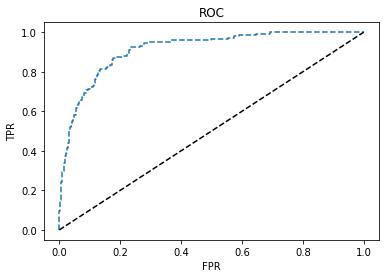

In [23]:
plt.plot(fpr, tpr, '--', label="Decision Tree")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.plot([fpr], [tpr], 'r-', ms=10)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

## 부록. Logistic Regress 회귀계수


- 전체변수 투입: sm.Logit(y, X)
- 특정변수만 넣고 싶을 때
- Logistic_ml = sm.Logit.from_formula("PersonalLoan ~  Age + Experience + Income + Family + CCAvg", bank_df)

In [24]:
import statsmodels.api as sm
logistic_ml = sm.Logit(y, X) #로지스틱 회귀분석 시행
logistic_coef = logistic_ml.fit()
logistic_coef.summary2()

Optimization terminated successfully.
         Current function value: 0.149214
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:                Logit            Pseudo R-squared: 0.528    
Dependent Variable:   PersonalLoan     AIC:              1516.1369
Date:                 2019-11-04 14:19 BIC:              1594.3432
No. Observations:     5000             Log-Likelihood:   -746.07  
Df Model:             11               LL-Null:          -1581.0  
Df Residuals:         4988             LLR p-value:      0.0000   
Converged:            1.0000           Scale:            1.0000   
No. Iterations:       9.0000                                      
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Age               -0.7512   0.6853  -1.0960 0.2731 -2.0944  0.5921
Experience         0.8612   0.6827   1.2615 0.2071 -0.4768  2.1992
Income             2.4375   0.1145  21.2843 0.0000  2.2130  2.6620
Family             0.3616   0.0714   5.0629 0.0000  0.2216  0.5016
CCAvg              0.3730   0.0748   4.9860 0.0000  0.2264  0.5196
Mortgage           0.0915   0.0576   1.5881 0.1123 -0.0214  0.2045
SecuritiesAccount -1.7463   0.2888  -6.0472 0.0000 -2.3123 -1.1803
CDAccount          4.9464   0.3341  14.8030 0.0000  4.2915  5.6013
Online            -2.1804   0.1350 -16.1499 0.0000 -2.4450 -1.9158
CreditCard        -2.1050   0.2029 -10.3758 0.0000 -2.5026 -1.7074
Education_Prof    -1.6077   0.1422 -11.3079 0.0000 -1.8864 -1.3290
Education_Under   -5.5799   0.2466 -22.6258 0.0000 -6.0633 -5.0965
==================================================================

"""

In [25]:
np.exp(logistic_coef.params)

Age                    0.471820
Experience             2.366013
Income                11.444403
Family                 1.435643
CCAvg                  1.452095
Mortgage               1.095844
SecuritiesAccount      0.174414
CDAccount            140.667639
Online                 0.112999
CreditCard             0.121845
Education_Prof         0.200348
Education_Under        0.003773
dtype: float64

## 7.최적화
- 교재 6장 (pp.218~250)

### 7.1 파이프라인 모델 만들기
- 파이프라인을 이용하여 최적 모델 만들기
- 기본모형은 아무 옵션이 없는 모델로 부터 시작
- 파라미터 옵션 확인: pipe_tree.get_params().keys()

In [26]:
pipe_logistic = make_pipeline(LogisticRegression(random_state=1))

In [27]:
pipe_logistic.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'logisticregression', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

### 7.2 학습 곡선으로 편향과 분산 문제 분석하기
- 훈렴 샘플링 수를 이용하여 편향과 분산 검정
- 편향: 정확도가 높은지 검정
- 분산: 훈련/검정 데이터의 정확도의 차이가 적은지

C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

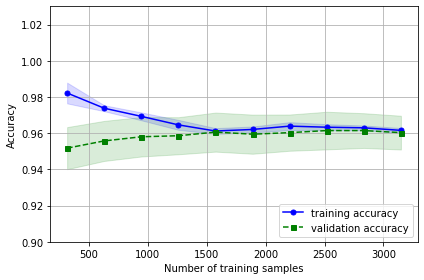

In [28]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_logistic, # 수정
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.9, 1.03])  # 수정
plt.tight_layout()
plt.show()

### 7.3 검증 곡선으로 과대적합과 과소적합 조사하기
- 과대적합 : 파라미터가 많음 -> 파라미터 축소
- 과소적합 : 파라미터가 적음 -> 파라미터 추가

C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

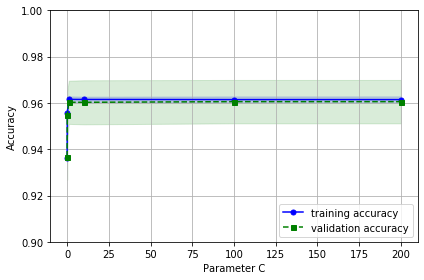

In [29]:
param_range = [0.01, 0.1, 1.0, 10, 100, 200]  # 수정

train_scores, test_scores = validation_curve(
                estimator=pipe_logistic, # 수정
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', ## 수정
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of C') # 수정
plt.legend(loc='lower right')
plt.xlabel('Parameter C') # 수정
plt.ylabel('Accuracy')
plt.ylim([0.9, 1.00])  # 수정
plt.tight_layout()
plt.show()

### 7.4 하이퍼파라미터 튜닝
- 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝
- 기계학습 모델의 성능을 결정하는 하이퍼 파라미터 튜닝

In [30]:
param_range = [0.01, 0.1, 1.0, 10, 100, 200]  # 수정

param_grid = [{'logisticregression__C': param_range}] # 수정

gs = GridSearchCV(estimator=pipe_logistic, # 수정
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.9605714285714285
{'logisticregression__C': 100}


C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## 8.최적화 모델 검정
- 최적모델을 이용해 검정 데이터(full data) 최종 확인
- best_tree 로 모델명 변경


In [31]:
best_logistic = gs.best_estimator_
best_logistic.fit(X_train, y_train)

C:\Users\leecho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('logisticregression',
                 LogisticRegression(C=100, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=1, solver='warn',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

- 검증용 데이터로 예측

In [32]:
y_pred = best_logistic.predict(X_test) 

- 정오분류표로 검정

In [33]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],1341,15
True[1],50,94


In [34]:
print('Classification Report')
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1356
           1       0.86      0.65      0.74       144

    accuracy                           0.96      1500
   macro avg       0.91      0.82      0.86      1500
weighted avg       0.95      0.96      0.95      1500



- 정확도, 민감도 확인
- 초기 모델
- 정확도: 0.917
- 정밀도: 0.794
- 재현율: 0.188
- F1: 0.303

In [35]:
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수: 65
정확도: 0.957
정밀도: 0.862
재현율: 0.653
F1: 0.743


- ROC 곡선 그리기

In [36]:
from sklearn.metrics import roc_curve

# fpr, tpr, thresholds = roc_curve(y_test, best_tree.decision_function(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best_logistic.predict_proba(X_test)[:, 1])

In [37]:
fpr, tpr, thresholds

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.37463127e-04,
        7.37463127e-04, 3.68731563e-03, 3.68731563e-03, 4.42477876e-03,
        4.42477876e-03, 5.16224189e-03, 5.16224189e-03, 5.89970501e-03,
        5.89970501e-03, 6.63716814e-03, 6.63716814e-03, 8.84955752e-03,
        8.84955752e-03, 9.58702065e-03, 9.58702065e-03, 1.03244838e-02,
        1.03244838e-02, 1.10619469e-02, 1.10619469e-02, 1.47492625e-02,
        1.47492625e-02, 1.91740413e-02, 1.91740413e-02, 2.13864307e-02,
        2.13864307e-02, 2.21238938e-02, 2.21238938e-02, 2.28613569e-02,
        2.28613569e-02, 3.09734513e-02, 3.09734513e-02, 3.31858407e-02,
        3.31858407e-02, 3.39233038e-02, 3.39233038e-02, 3.83480826e-02,
        3.83480826e-02, 4.12979351e-02, 4.12979351e-02, 4.94100295e-02,
        4.94100295e-02, 5.23598820e-02, 5.23598820e-02, 5.30973451e-02,
        5.30973451e-02, 5.97345133e-02, 5.97345133e-02, 7.89085546e-02,
        7.89085546e-02, 8.62831858e-02, 8.62831858e-02, 9.513274

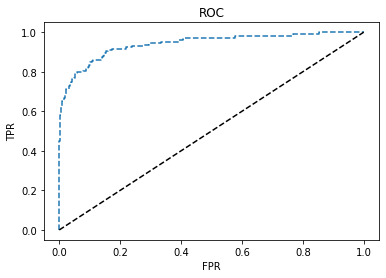

In [38]:
plt.plot(fpr, tpr, '--', label="Decision Tree")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.plot([fpr], [tpr], 'r-', ms=10)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()